# Import Libraries and Startup Necessities

In [1]:
import pandas as pd
from tqdm import tqdm, trange
import numpy as np
import os
import gc
import time

from matplotlib import pyplot as plt
from skimage.transform import resize
import seaborn as sns

from keras.applications.mobilenet import preprocess_input as preprocess_input_v1, decode_predictions as decode_predictions_v1
from keras.applications.resnet import preprocess_input as preprocess_input_resnet, decode_predictions as decode_predictions_resnet
from keras.utils import load_img, img_to_array, to_categorical
from keras.applications import MobileNet, ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam, AdamW, RMSprop, SGD
from keras.losses import CategoricalCrossentropy
# from keras.metrics import Accuracy
from tensorflow.keras.metrics import F1Score
from keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import wandb
from wandb.keras import WandbCallback

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Initialize Wandb

Use Kaggle Secret to store my Wandb API

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")

Login to Wandb using my own Wandb API Key stored on Kaggle Secret

In [3]:
wandb.login(key=secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Loading Dataset and Exploratory Data Analysis (EDA)

In [4]:
ALL_NAMES = "/kaggle/input/lfw-dataset/lfw_allnames.csv"
IMAGES_SRC = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"
PEOPLE = "/kaggle/input/lfw-dataset/people.csv"
PEOPLE_TEST = "/kaggle/input/lfw-dataset/peopleDevTest.csv"
PEOPLE_TRAIN = "/kaggle/input/lfw-dataset/peopleDevTrain.csv"
README = "/kaggle/input/lfw-dataset/lfw_readme.csv"
WORK_DIR = "/kaggle/working/"

In [5]:
df_all = pd.read_csv(ALL_NAMES)
df_all = df_all.sort_values(by="images", ascending=False) # Descending
df_all.describe()

,images
count,5749.000000
mean,2.301792
std,9.016410
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,530.000000


As we can see on the dataframe description above, the maximum data is 530 but the 3rd quartile is 2. This indicate a highly imbalance data. So, I would like to filter only use the data whose images count is > 20

In [6]:
df_all = df_all[df_all["images"] > 20]

In [7]:
unique_name_count = df_all['name'].nunique()

# Display the count of unique values in the "name" column
print("Count of unique names:", unique_name_count)
print("Count of all data:", df_all["images"].sum())

Count of unique names: 57
Count of all data: 2923


As we can see, this only gives us 7 classes/names after filtering, with total data 1288.

# Data Preprocessing

Loading the data set. This step follows the reference: https://keras.io/api/applications/#classify-imagenet-classes-with-resnet50.

In [8]:
X = []
Y = []

tqdm_all_names = tqdm(list(df_all["name"]), colour="blue")

for name in tqdm_all_names:
    dir_path = os.path.join(IMAGES_SRC, name)
    list_images_name = os.listdir(dir_path)
    
    for image_name in list_images_name:
        images_path = os.path.join(dir_path, image_name)
        rgb_image = load_img(images_path, target_size=(224, 224))
        x = img_to_array(rgb_image)
        x = np.expand_dims(x, axis=0)
        x_v1 = preprocess_input_v1(x)
        X.append(x_v1)
        Y.append(name)

X = np.asarray(X)
Y = np.asarray(Y)

100%|██████████| 57/57 [00:24<00:00,  2.37it/s]


## Label Encoding

We use one-hot encoding to transform out label from text to number so the machine could understand it. One-hot encoder is used because the MobileNet requires for each label to be a list of its classes, much like sparse-encoding.

In [9]:
encoder = OneHotEncoder(dtype=np.float32)

In [10]:
# Fit and transform the data
encoded_Y = encoder.fit_transform(Y.reshape(-1, 1))
encoded_Y = encoded_Y.toarray()

In [11]:
encoded_Y.shape

(2923, 57)

## Train-Dev-Test Split

Train : Dev : Test = 70 : 15 : 15

I tried to use stratify=Y_temp on `X_dev, X_test, Y_dev, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=30, stratify=Y_temp)` but it showed error "The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2."

So I use the regular `train_test_split` function from Scikit-learn.

In [12]:
X1_train, X1_temp, Y1_train, Y1_temp = train_test_split(X, encoded_Y, test_size=0.3, random_state=30)
X1_dev, X1_test, Y1_dev, Y1_test = train_test_split(X1_temp, Y1_temp, test_size=0.5, random_state=30)

Next, I try to reshape the resulting dimension to be of (n_samples, 224, 224, 3).

In [13]:
NEW_SHAPE = (-1, 224, 224, 3)
X1_train = X1_train.reshape(NEW_SHAPE)
X1_dev = X1_dev.reshape(NEW_SHAPE)
X1_test = X1_test.reshape(NEW_SHAPE)
print("X1_train shape:", X1_train.shape)
print("X1_dev shape:", X1_dev.shape)
print("X1_test shape:", X1_test.shape)

X1_train shape: (2046, 224, 224, 3)
X1_dev shape: (438, 224, 224, 3)
X1_test shape: (439, 224, 224, 3)


In [14]:
print("Y1_train shape:", Y1_train.shape)
print("Y1_dev shape:", Y1_dev.shape)
print("Y1_test shape:", Y1_test.shape)

Y1_train shape: (2046, 57)
Y1_dev shape: (438, 57)
Y1_test shape: (439, 57)


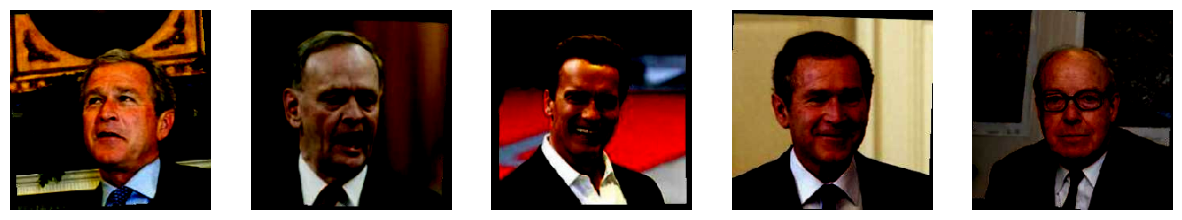

In [15]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, img in enumerate(X1_train[:5]):
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()

# AI Modelling

## Model Declaration

For the base model, I use MobileNet with "imagenet" as the initial weights. The base model is loaded without its classifier head.

In [16]:
mobilenet_mdl = MobileNet(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet",
)

17225924/17225924 [==============================] - 0s 0us/step


In [17]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomContrast(factor=0.2),
  tf.keras.layers.RandomBrightness(factor=0.3),
])

Then, add a custom classifier head

In [18]:
def head_model(base_model, n_classes):
    inputs = base_model.input
    aug = data_augmentation(inputs)
    top_model = base_model.output
    top_model = GlobalAveragePooling2D(data_format="channels_last")(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dropout(0.69)(top_model)
    top_model = Dense(1000, activation="relu")(top_model)
    top_model = Dropout(0.55)(top_model)
    top_model = Dense(n_classes, activation="softmax")(top_model)
    return top_model

Stack the classifier head on the top of the base model

In [19]:
model_mobilenet_head = head_model(mobilenet_mdl, encoded_Y.shape[1])
model_mobilenet = Model(inputs = mobilenet_mdl.input, outputs = model_mobilenet_head)

Freeze other than the top 6 layers (or, train the classifier heads), so that the trainable neurons is the one on the custom classifier head.

In [20]:
for layer in model_mobilenet.layers[:-6]:
    layer.trainable = False

Look at the declared model architecture

In [21]:
model_mobilenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

We can see the trainable params/neurons above is the same as the sum of the number of neurons from the last 6 layers. This indicates that we have freezed the base model.

## Training

### Helper Functions

Create helper function to plot the training process

In [22]:
def plot_training_history(history):
    # Plot training and validation accuracy values
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['f1_score'], label='Training')
    plt.plot(history.history['val_f1_score'], label='Validation')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    # Plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Create helper function to warmup learning rate while training. This help the model to utilize high learning rate for a few epochs, then exponentially decrease the learning rate.

In [23]:
def scheduler(running_epoch, learning_rate):
    try:
        if running_epoch <= 10:
            return learning_rate
        else:
            if learning_rate < float(1e-6): # Do NOT make the learning rate any lower than 1e-6
                return learning_rate
            else:
                return learning_rate * tf.math.exp(-0.1)
    except Exception as e:
        print(f"Error while returning the scheduler LR!", e)

Create helper function to show time elapsed

In [24]:
def training_time_elapsed(elapsed_time):
    # Format the elapsed time
    hours, remainder = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    if hours >= 1:
        print(f"The training goes by {int(hours)} hour, {int(minutes)} minutes, and {int(seconds)} seconds.")
    elif minutes >= 1:
        print(f"The training goes by {int(minutes)} minutes and {int(seconds)} seconds.")
    else:
        print(f"The training goes by {int(seconds)} seconds.")

## Train and Validation

### Phase I: Train the Classifier Head

Initializing Wandb for Phase I - Train and Validation

In [25]:
# Initialize WandB
wandb.init(
    project="face-recognition-lfw",
    name="phase1-train-n-validate"
)

wandb: Currently logged in as: art-oliynyk1 (artoliinyk). Use `wandb login --relogin` to force relogin


Describing hyperparameters used

In [26]:
# Hyperparameters Phase 1
BATCH_SIZE_phase1 = 64
EPOCHS_phase1 = 150
LEARNING_RATE_phase1 = 3e-4
L2_REGULARIZATION_phase1 = 4e-5

Describing loss function, optimizer, and metrics used when training the model. I use F1-Score because of the imbalance dataset case.

In [27]:
optimizer_mobilenet_phase1 = AdamW(
    learning_rate=LEARNING_RATE_phase1,
    weight_decay=L2_REGULARIZATION_phase1,
)
loss_function_mobilenet_phase1 = CategoricalCrossentropy()
early_stopping_phase1 = EarlyStopping(monitor='val_f1_score', mode="max", start_from_epoch=10, patience=25, restore_best_weights=True)
scheduler_phase1 = LearningRateScheduler(scheduler)
wandb_phase1 = WandbCallback(save_model=False)

model_mobilenet.compile(
    loss = loss_function_mobilenet_phase1,
    optimizer = optimizer_mobilenet_phase1,
    metrics=[F1Score(average="micro", dtype=np.float32)]
)

Train the model!

Training MobileNet Phase 1...


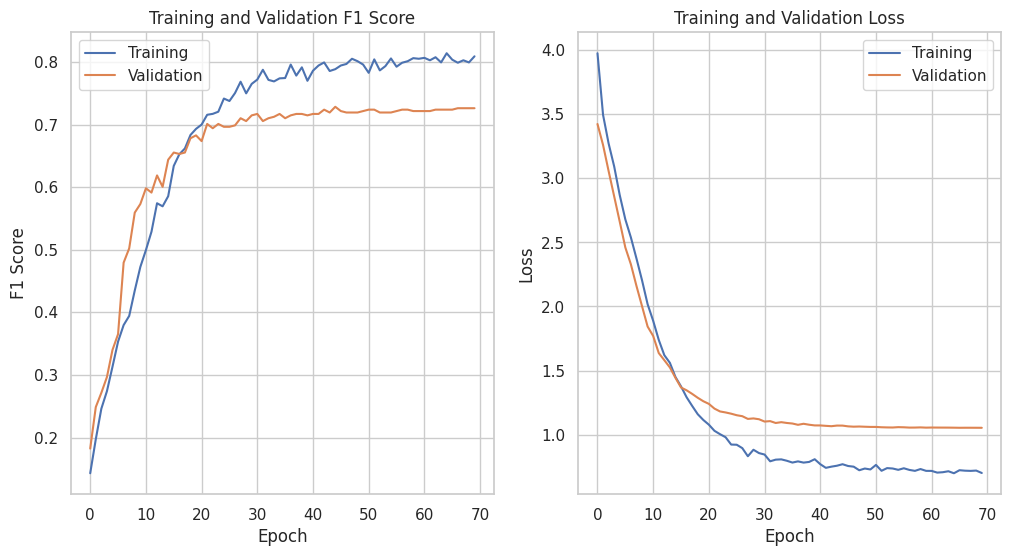

The training goes by 2 minutes and 37 seconds.


In [28]:
try:
    print("Training MobileNet Phase 1...")
    start_time1 = time.time()
    training_history = model_mobilenet.fit(
        batch_size=BATCH_SIZE_phase1,
        epochs=EPOCHS_phase1,
        x=X1_train,
        y=Y1_train,
        shuffle=True,
        validation_data=(X1_dev, Y1_dev),
        callbacks=[
            early_stopping_phase1,
            scheduler_phase1,
            wandb_phase1,
        ],
        verbose=0 if EPOCHS_phase1 > 50 else 1,
    )
    elapsed_time1 = time.time() - start_time1
    
    plot_training_history(training_history)
    training_time_elapsed(elapsed_time1)
except Exception as e:
    print("Error while training MobileNet!", e)

Evaluate the first phase using development data

In [29]:
result_eval_mobilenet_phase1 = model_mobilenet.evaluate(X1_dev, Y1_dev, batch_size=BATCH_SIZE_phase1)

7/7 [==============================] - 0s 52ms/step - loss: 1.0704 - f1_score: 0.7283


In [30]:
print(f"F1 Score of the MobileNet Phase 1: {round(result_eval_mobilenet_phase1[1] * 100, 2)}%")

F1 Score of the MobileNet Phase 1: 72.83%


The resulting validation vs training F1-Score and its loss is looking good! No sign of overfitting. The initial Phase I training validation F1-Score is 90s%

Finish the current Wandb logging run

In [31]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▂▂▃▄▄▅▆▆▆▆▇▇▇▇▇▇███████████████████████
loss,█▇▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,▁▂▂▃▅▆▆▇▇▇▇▇████████████████████████████
val_loss,██▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,69
best_val_loss,1.05329
epoch,69
f1_score,0.8089
loss,0.70056


### Phase II: Train the 2 Top MobileNet Blocks

Initialize new Wandb run

In [32]:
# Initialize WandB
wandb.init(
    project="face-recognition-lfw",
    name="phase2-train-n-validate"
)

In [33]:
print(f"Base model has {len(mobilenet_mdl.layers)} layers.")

Base model has 86 layers.


Next, I want to train the 2 top MobileNet Convolutional Layers. Unfreeze starting from the 2 top MobileNet Convolutional Layers, and freeze the other layers. This means we unfreeze the last 2 Convolutional Layers (Conv2D), all the way to the last layers. The previous layers should be freezed.

In [34]:
for layer in model_mobilenet.layers[:len(model_mobilenet.layers)-15]:
    layer.trainable = False
    
for layer in model_mobilenet.layers[len(model_mobilenet.layers)-15:]:
    layer.trainable = True

In [35]:
# Hyperparameters Phase 2
BATCH_SIZE_phase2 = 32
EPOCHS_phase2 = 100
LEARNING_RATE_phase2 = 1e-4
L2_REGULARIZATION_phase2 = 4e-5

In [36]:
optimizer_mobilenet_phase2 = AdamW(
    learning_rate=LEARNING_RATE_phase2,
    weight_decay=L2_REGULARIZATION_phase2
)
loss_function_mobilenet_phase2 = CategoricalCrossentropy()
early_stopping_phase2 = EarlyStopping(monitor='val_f1_score', mode="max", start_from_epoch=10, patience=25, restore_best_weights=True)
scheduler_phase2 = LearningRateScheduler(scheduler)
wandb_phase2 = WandbCallback(save_model=False)

model_mobilenet.compile(
    loss = loss_function_mobilenet_phase2,
    optimizer = optimizer_mobilenet_phase2,
    metrics=[F1Score(average="micro", dtype=np.float32)]
)

Training MobileNet Phase 2...


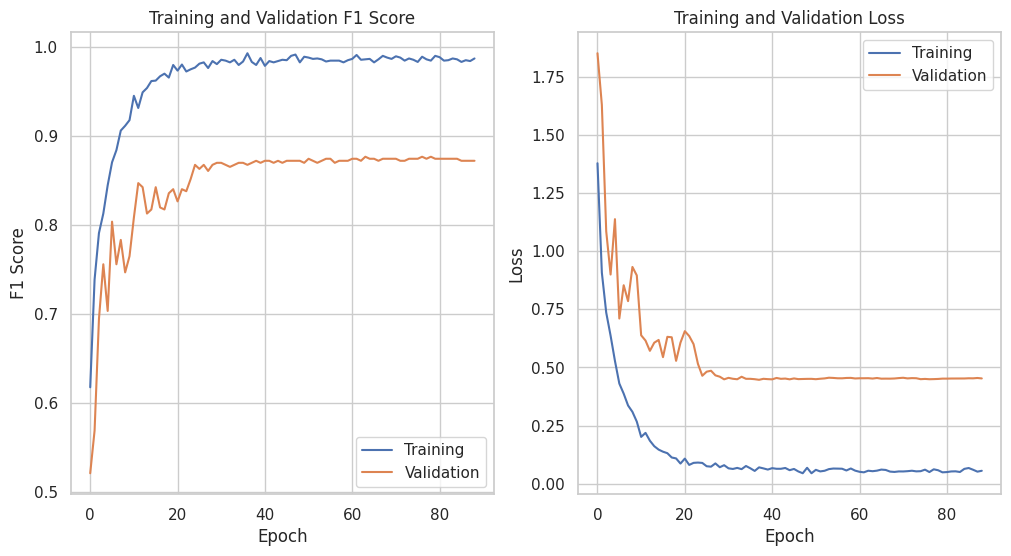

The training goes by 3 minutes and 43 seconds.


In [37]:
try:
    print("Training MobileNet Phase 2...")
    start_time1 = time.time()
    training_history = model_mobilenet.fit(
        batch_size=BATCH_SIZE_phase2,
        epochs=EPOCHS_phase2,
        x=X1_train,
        y=Y1_train,
        shuffle=True,
        validation_data=(X1_dev, Y1_dev),
        callbacks=[
            early_stopping_phase2,
            scheduler_phase2,
            wandb_phase2,
        ],
        verbose=0 if EPOCHS_phase2 > 50 else 1,
    )
    elapsed_time1 = time.time() - start_time1
    
    plot_training_history(training_history)
    training_time_elapsed(elapsed_time1)
except Exception as e:
    print("Error while training MobileNet!", e)

Evaluate the second phase with development data

In [38]:
result_eval_mobilenet_phase2 = model_mobilenet.evaluate(X1_dev, Y1_dev, batch_size=BATCH_SIZE_phase2)

14/14 [==============================] - 0s 30ms/step - loss: 0.4523 - f1_score: 0.8767


In [39]:
print(f"F1 Score of the MobileNet Phase 2: {round(result_eval_mobilenet_phase2[1] * 100, 2)}%")

F1 Score of the MobileNet Phase 2: 87.67%


The resulting training vs validation loss and F1-Score graphs are looking good! No sign of overfitting. The evaluation of the 2nd Phase is the F1-Score of 95s%. This implicates that training the classifier head first then train the 2 last Convolutional Layers improves the resulting F1-Score.

Finish the current Wandb logging run

In [40]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▄▅▆▇▇▇▇▇███████████████████████████████
loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,▁▄▅▆▆▇▇▇▇▇▇█████████████████████████████
val_loss,█▄▄▃▃▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,37
best_val_loss,0.44686
epoch,88
f1_score,0.98729
loss,0.05577


## Holdout Validation

I use holdout strategy here. I'm going to combine the training and validation/development data to create a new "holdout" data. This holdout data is going to be tested against the testing data.

In [41]:
# Concatenate the arrays along the first axis
X1_holdout = np.concatenate((X1_train, X1_dev), axis=0)
Y1_holdout = np.concatenate((Y1_train, Y1_dev), axis=0)

### Phase I: Train the Classifier Head

Initialize new Wandb logging run

In [42]:
# Initialize WandB
wandb.init(
    project="face-recognition-lfw",
    name="phase1-holdout"
)

Re-freeze the model's layers except the last 6 layers.

In [43]:
for layer in model_mobilenet.layers[:-6]:
    layer.trainable = False

Define hyperparameters for holdout phase 1

In [44]:
# Hyperparameters holdout Phase 1
BATCH_SIZE_holdout_phase1 = 32
EPOCHS_holdout_phase1 = 20
LEARNING_RATE_holdout_phase1 = 2e-4
L2_REGULARIZATION_holdout_phase1 = 4e-5

Define the loss function, optimizer, callback functions, and compile the model again

In [45]:
optimizer_mobilenet_holdout_phase1 = AdamW(
    learning_rate=LEARNING_RATE_holdout_phase1,
    weight_decay=L2_REGULARIZATION_holdout_phase1
)
loss_function_mobilenet_holdout_phase1 = CategoricalCrossentropy()
early_stopping_holdout_phase1 = EarlyStopping(monitor='val_f1_score', mode="max", start_from_epoch=10, patience=25, restore_best_weights=True)
scheduler_holdout_phase1 = LearningRateScheduler(scheduler)
wandb_holdout_phase1 = WandbCallback(save_model=False)

model_mobilenet.compile(
    loss = loss_function_mobilenet_holdout_phase1,
    optimizer = optimizer_mobilenet_holdout_phase1,
    metrics=[
        F1Score(average="micro", dtype=np.float32),
    ]
)

Re-train the model using Holdout data

Training MobileNet Holdout Phase 1...


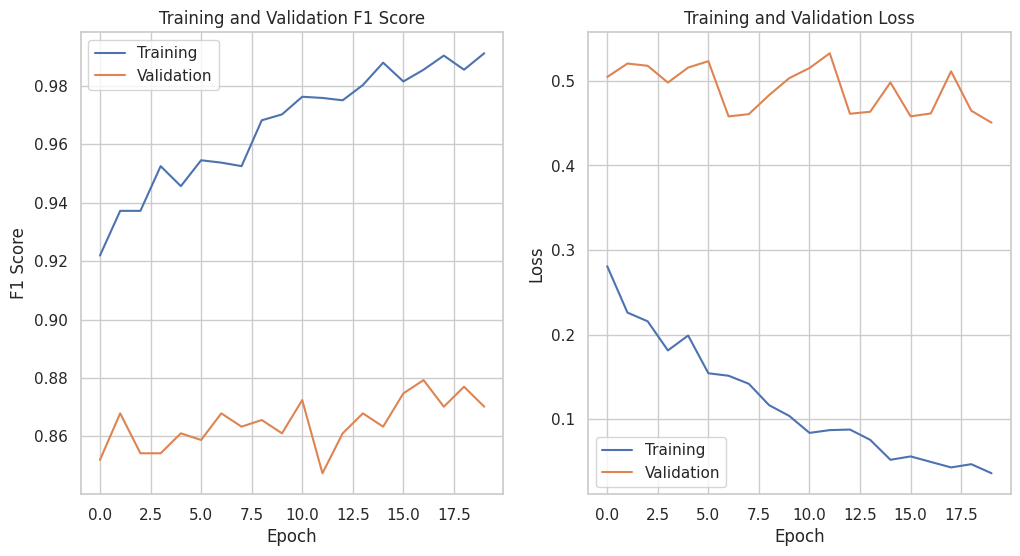

The training goes by 1 minutes and 2 seconds.


In [46]:
try:
    print("Training MobileNet Holdout Phase 1...")
    start_time1 = time.time()
    training_history = model_mobilenet.fit(
        batch_size=BATCH_SIZE_holdout_phase1,
        epochs=EPOCHS_holdout_phase1,
        x=X1_holdout,
        y=Y1_holdout,
        shuffle=True,
        validation_data=(X1_test, Y1_test),
        callbacks=[
            early_stopping_holdout_phase1,
            scheduler_holdout_phase1,
            wandb_holdout_phase1,
        ],
        verbose=0,
    )
    elapsed_time1 = time.time() - start_time1
    
    plot_training_history(training_history)
    training_time_elapsed(elapsed_time1)
except Exception as e:
    print("Error while training MobileNet!", e)

In [47]:
result_eval_mobilenet_holdout_phase1 = model_mobilenet.evaluate(X1_test, Y1_test, batch_size=BATCH_SIZE_holdout_phase1)

14/14 [==============================] - 0s 29ms/step - loss: 0.4506 - f1_score: 0.8702


In [48]:
print(f"F1 Score of the MobileNet Holdout Phase 1: {round(result_eval_mobilenet_holdout_phase1[1] * 100, 2)}%")

F1 Score of the MobileNet Holdout Phase 1: 87.02%


Finish the current Wandb logging run

In [49]:
wandb.finish()

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
f1_score,▁▃▃▄▃▄▄▄▆▆▆▆▆▇█▇▇█▇█
loss,█▆▆▅▆▄▄▄▃▃▂▂▂▂▁▂▁▁▁▁
lr,███████████▇▆▅▄▃▃▂▂▁
val_f1_score,▂▅▃▃▄▄▅▄▅▄▆▁▄▅▄▇█▆▇▆
val_loss,▆▇▇▅▇▇▂▂▄▅▇█▂▂▅▂▂▆▂▁
best_epoch,19
best_val_loss,0.45058
epoch,19
f1_score,0.99114
loss,0.03592


### Phase II: Train the 2 Top MobileNet Blocks

Initialize a new Wandb logging run

In [50]:
# Initialize WandB
wandb.init(
    project="face-recognition-lfw",
    name="phase2-holdout"
)

Unfreeze the base model/MobileNet model except the 2 last Convolutional layers and keep the other layers to be frozen.

In [51]:
for layer in model_mobilenet.layers[:len(model_mobilenet.layers)-15]:
    layer.trainable = False
    
for layer in model_mobilenet.layers[len(model_mobilenet.layers)-15:]:
    layer.trainable = True

Define the hyperparameters used for Phase 2 of the holdout training

In [52]:
# Hyperparameters holdout Phase 2
BATCH_SIZE_holdout_phase2 = 32
EPOCHS_holdout_phase2 = 100
LEARNING_RATE_holdout_phase2 = 1e-4
L2_REGULARIZATION_holdout_phase2 = 4e-5

Re-compile the model again

In [53]:
optimizer_mobilenet_holdout_phase2 = AdamW(
    learning_rate=LEARNING_RATE_holdout_phase2,
    weight_decay=L2_REGULARIZATION_holdout_phase2
)
loss_function_mobilenet_holdout_phase2 = CategoricalCrossentropy()
early_stopping_holdout_phase2 = EarlyStopping(monitor='val_f1_score', mode="max", start_from_epoch=10, patience=20, restore_best_weights=True)
scheduler_holdout_phase2 = LearningRateScheduler(scheduler)
wandb_holdout_phase2 = WandbCallback(save_model=False)

model_mobilenet.compile(
    loss = loss_function_mobilenet_holdout_phase2,
    optimizer = optimizer_mobilenet_holdout_phase2,
    metrics=[
        F1Score(average="micro", dtype=np.float32),
    ]
)

Training MobileNet Holdout Phase 2...


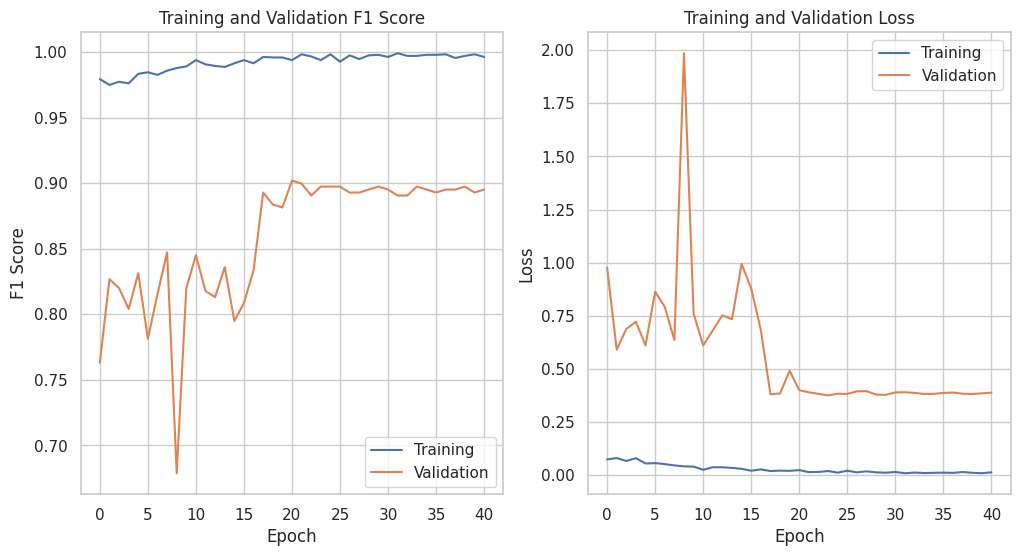

The training goes by 2 minutes and 5 seconds.


In [54]:
try:
    print("Training MobileNet Holdout Phase 2...")
    start_time1 = time.time()
    training_history = model_mobilenet.fit(
        batch_size=BATCH_SIZE_holdout_phase2,
        epochs=EPOCHS_holdout_phase2,
        x=X1_holdout,
        y=Y1_holdout,
        shuffle=True,
        validation_data=(X1_test, Y1_test),
        callbacks=[
            early_stopping_holdout_phase2,
            scheduler_holdout_phase2,
            wandb_holdout_phase2
        ],
        verbose=0 if EPOCHS_holdout_phase2 > 50 else 1,
    )
    elapsed_time1 = time.time() - start_time1
    
    plot_training_history(training_history)
    training_time_elapsed(elapsed_time1)
except Exception as e:
    print("Error while training MobileNet!", e)

Evaluating the holdout Phase 2

In [55]:
result_eval_mobilenet_holdout_phase2 = model_mobilenet.evaluate(X1_test, Y1_test, batch_size=BATCH_SIZE_holdout_phase2)

14/14 [==============================] - 0s 29ms/step - loss: 0.3988 - f1_score: 0.9021


In [56]:
print(f"F1 Score of the MobileNet Holdout Phase 2: {round(result_eval_mobilenet_holdout_phase2[1] * 100, 2)}%")

F1 Score of the MobileNet Holdout Phase 2: 90.21%


Finalize the current Wandb logging run

In [57]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
f1_score,▂▁▂▁▃▄▃▄▅▅▆▆▅▅▆▆▆▇▇▇▆█▇▆█▆█▇██▇█▇▇███▇▇▇
loss,▇█▇█▅▆▅▅▄▄▃▄▄▃▃▂▃▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁
lr,███████████▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_f1_score,▄▆▅▅▆▄▅▆▁▅▆▅▅▆▅▅▆█▇▇████████████████████
val_loss,▄▂▂▃▂▃▃▂█▃▂▂▃▃▄▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,23
best_val_loss,0.37462
epoch,40
f1_score,0.99638
loss,0.01213


# Performance Report & Analysis

## Evaluate

In [58]:
gc.collect() # garbage collection

19946

Let's test it using the unseen testing data!

In [59]:
result_mobilenet = model_mobilenet.evaluate(X1_test, Y1_test, batch_size=BATCH_SIZE_holdout_phase2)

14/14 [==============================] - 0s 29ms/step - loss: 0.3988 - f1_score: 0.9021


## Result

In [60]:
print(f"F1 Score MobileNet: {round(result_mobilenet[1] * 100, 2)}%")

F1 Score MobileNet: 90.21%


The result is pretty good!

## Classification Result

In [61]:
predict_mobilenet = model_mobilenet.predict(X1_test, batch_size=BATCH_SIZE_holdout_phase2)

14/14 [==============================] - 1s 26ms/step


In [62]:
Y_pred_1dim = np.argmax(predict_mobilenet, axis=1)

In [63]:
Y_test_1dim = np.argmax(Y1_test, axis=1)

In [64]:
print(classification_report(y_true = Y_test_1dim, y_pred = Y_pred_1dim))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.67      0.80         6
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         8
           4       0.73      1.00      0.84         8
           5       0.75      0.75      0.75         4
           6       1.00      0.67      0.80         3
           7       1.00      1.00      1.00         1
           9       1.00      1.00      1.00        27
          10       1.00      0.67      0.80         3
          11       0.97      1.00      0.98        30
          12       1.00      1.00      1.00         5
          13       0.93      0.99      0.96        67
          14       0.86      0.80      0.83        15
          15       0.91      1.00      0.95        10
          16       0.50      0.50      0.50         4
          17       1.00      1.00      1.00         1
          18       1.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
encoder.categories_[0]

array(['Alejandro_Toledo', 'Alvaro_Uribe', 'Amelie_Mauresmo',
       'Andre_Agassi', 'Ariel_Sharon', 'Arnold_Schwarzenegger',
       'Atal_Bihari_Vajpayee', 'Bill_Clinton', 'Carlos_Menem',
       'Colin_Powell', 'David_Beckham', 'Donald_Rumsfeld',
       'George_Robertson', 'George_W_Bush', 'Gerhard_Schroeder',
       'Gloria_Macapagal_Arroyo', 'Gray_Davis', 'Guillermo_Coria',
       'Hamid_Karzai', 'Hans_Blix', 'Hugo_Chavez', 'Jack_Straw',
       'Jacques_Chirac', 'Jean_Chretien', 'Jennifer_Aniston',
       'Jennifer_Capriati', 'Jennifer_Lopez', 'Jeremy_Greenstock',
       'John_Ashcroft', 'John_Negroponte', 'Jose_Maria_Aznar',
       'Juan_Carlos_Ferrero', 'Junichiro_Koizumi', 'Kofi_Annan',
       'Laura_Bush', 'Lindsay_Davenport', 'Lleyton_Hewitt',
       'Luiz_Inacio_Lula_da_Silva', 'Mahmoud_Abbas',
       'Megawati_Sukarnoputri', 'Naomi_Watts', 'Nestor_Kirchner',
       'Pete_Sampras', 'Recep_Tayyip_Erdogan', 'Ricardo_Lagos',
       'Roh_Moo-hyun', 'Rudolph_Giuliani', 'Saddam_Huss

In [66]:
conf_matrice = confusion_matrix(y_true = Y_test_1dim, y_pred = Y_pred_1dim)

<Axes: >

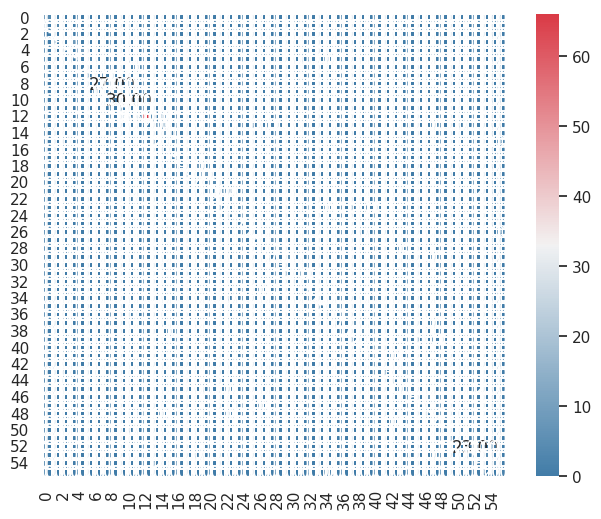

In [67]:
# Define a color map (blue for higher values, red for lower values)
cmap = sns.diverging_palette(240, 10, as_cmap=True)
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrice, annot=True, fmt=".2f", cmap=cmap, linewidths=.5, square=True)

In [68]:
final_accuracy = accuracy_score(y_true=Y_test_1dim, y_pred=Y_pred_1dim)
final_f1_score = f1_score(y_true=Y_test_1dim, y_pred=Y_pred_1dim, average="micro")

print(f"Final Accuracy: {round(final_accuracy * 100, 2)}%")
print(f"Final F1 Score: {round(final_f1_score * 100, 2)}%")

Final Accuracy: 90.21%
Final F1 Score: 90.21%


# Error Analysis

In [69]:
true_labels = encoder.categories_[0]
for i_test in range(len(Y_test_1dim)):
    data_in_true = Y_test_1dim[i_test]
    data_in_pred = Y_pred_1dim[i_test]
    
    if data_in_true != data_in_pred:
        print(f"True label: {true_labels[data_in_true]}")
        print(f"Predicted: {true_labels[data_in_pred]}")
        print("===========")

True label: Jennifer_Aniston
Predicted: Naomi_Watts
True label: Vicente_Fox
Predicted: Jack_Straw
True label: Jean_Chretien
Predicted: George_W_Bush
True label: Megawati_Sukarnoputri
Predicted: Gloria_Macapagal_Arroyo
True label: Rudolph_Giuliani
Predicted: Jacques_Chirac
True label: Jennifer_Aniston
Predicted: Laura_Bush
True label: Gray_Davis
Predicted: Vladimir_Putin
True label: Jacques_Chirac
Predicted: Vladimir_Putin
True label: Vladimir_Putin
Predicted: Gray_Davis
True label: Winona_Ryder
Predicted: Laura_Bush
True label: Alvaro_Uribe
Predicted: George_W_Bush
True label: Roh_Moo-hyun
Predicted: Alejandro_Toledo
True label: Jacques_Chirac
Predicted: Vladimir_Putin
True label: Laura_Bush
Predicted: Jennifer_Lopez
True label: Ricardo_Lagos
Predicted: Ariel_Sharon
True label: Jeremy_Greenstock
Predicted: Vladimir_Putin
True label: Rudolph_Giuliani
Predicted: Vladimir_Putin
True label: Alvaro_Uribe
Predicted: George_W_Bush
True label: John_Negroponte
Predicted: Recep_Tayyip_Erdogan
Tr

We have the falsely predicted label above and its supposed-to-be-true label. Then, we compare it with the most data from our dataset.

In [70]:
df_all.sort_values(by="images", ascending=False).head(3)

,name,images
1871,George_W_Bush,530
1047,Colin_Powell,236
5458,Tony_Blair,144


HA! As expected, our model tends to classify the images as the class that has the largest amount of data: **George W Bush**, **Colin Powell**, and **Tony Blair**.

We could add more data to the other classes to balance them out, or we could implement augmentation techniques to add more data.

# Saving the Model

Initialize Wandb again to log the model

In [71]:
# Initialize WandB
run = wandb.init(
    project="face-recognition-lfw"
)

In [72]:
filename = "mobilenet_facerecognition.keras"
model_mobilenet.save(os.path.join(WORK_DIR, filename))

In [73]:
model_artifact = wandb.Artifact(
  name=filename, 
  type="model"
)
model_artifact.add_file(os.path.join(WORK_DIR, filename))
run.log_artifact(model_artifact)
wandb.finish()